In [1]:
import pandas as pd

# Load your dataset (update the filename as needed)
df = pd.read_csv('IMDB Dataset.csv')  # Replace with your actual file path

# Display the first few rows
print(df.head())

# Check column names
print(df.columns)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Index(['review', 'sentiment'], dtype='object')


In [2]:
df.columns = ['review', 'sentiment']

In [15]:
import re
import nltk
from nltk.corpus import words

# Download once if not already done
nltk.download('words')

# Load English word set
english_words = set(words.words())

def clean_review(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()

    # Remove non-ASCII characters
    text = text.encode("ascii", errors="ignore").decode()

    # Remove punctuation and special characters, but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Split into words
    words_list = text.split()

    # Filter: remove words containing digits and keep only English words of length > 1
    cleaned_words = [
        word for word in words_list
        if word.isalpha() and len(word) > 1 and word in english_words
    ]

    return ' '.join(cleaned_words)

# Apply the updated function
df['clean_review'] = df['review'].apply(clean_review)

# Preview cleaned data
print(df[['review', 'clean_review']].head())


[nltk_data] Downloading package words to
[nltk_data]     /Users/ghanagokulgabburi/nltk_data...
[nltk_data]   Package words is already up-to-date!


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                        clean_review  
0  one of the other that after watching just epis...  
1  wonderful little production the technique is v...  
2  thought this was wonderful way to spend time o...  
3  basically theres family where little boy jake ...  
4  petter love in the time of money is visually s...  


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Initial high max_features just to capture full vocabulary
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(df['clean_review'])

# Check total number of unique words (features)
print("Total words (features):", len(vectorizer.get_feature_names_out()))

Total words (features): 30962


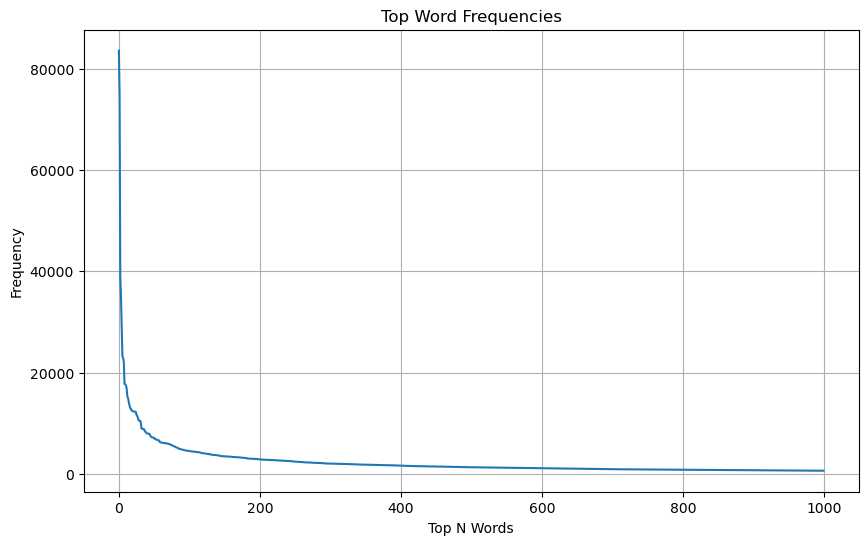

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Sum word frequencies across all documents
word_freq = np.asarray(X_counts.sum(axis=0)).ravel()
sorted_freq = np.sort(word_freq)[::-1]

# Plot top N frequencies
plt.figure(figsize=(10,6))
plt.plot(sorted_freq[:1000])
plt.title("Top Word Frequencies")
plt.xlabel("Top N Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [19]:
from sklearn.feature_selection import SelectKBest, chi2

# Use chi-squared to select top k words correlated with the sentiment
for k in [500, 1000, 2000, 3000, 5000]:
    selector = SelectKBest(chi2, k=k)
    X_selected = selector.fit_transform(X_counts, df['sentiment'])
    print(f"Selected top {k} features. Shape: {X_selected.shape}")

Selected top 500 features. Shape: (50000, 500)
Selected top 1000 features. Shape: (50000, 1000)
Selected top 2000 features. Shape: (50000, 2000)
Selected top 3000 features. Shape: (50000, 3000)
Selected top 5000 features. Shape: (50000, 5000)


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Use a high limit (or no limit) to capture full vocabulary
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(df['clean_review'])
y = df['sentiment']


In [22]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Define your k values (top N features to try)
k_values = [500, 1000, 2000, 3000, 5000, 7000, 10000]
results = []

for k in k_values:
    # Feature selection
    selector = SelectKBest(score_func=chi2, k=k)
    X_selected = selector.fit_transform(X_counts, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results.append((k, accuracy))
    print(f"Top {k} features => Accuracy: {accuracy:.4f}")


Top 500 features => Accuracy: 0.8454
Top 1000 features => Accuracy: 0.8519
Top 2000 features => Accuracy: 0.8552
Top 3000 features => Accuracy: 0.8572
Top 5000 features => Accuracy: 0.8571
Top 7000 features => Accuracy: 0.8583
Top 10000 features => Accuracy: 0.8565


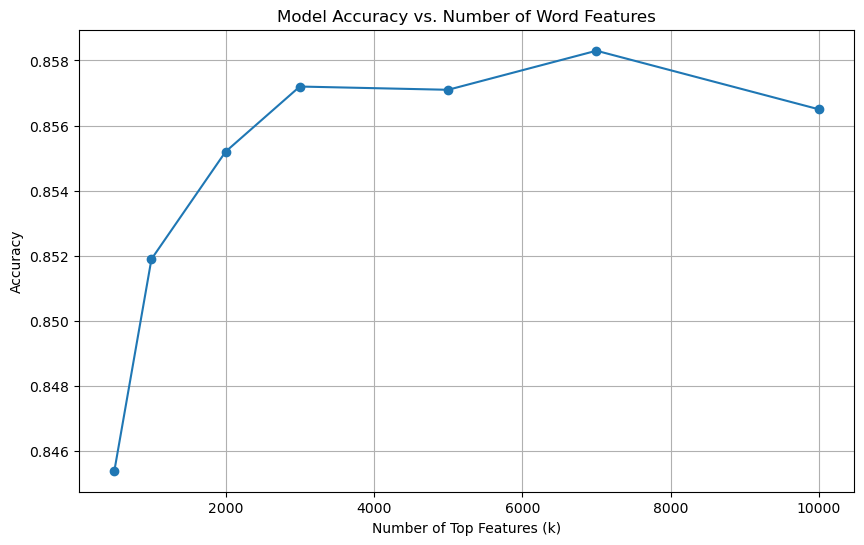

In [23]:
import matplotlib.pyplot as plt

k_vals, acc_vals = zip(*results)
plt.figure(figsize=(10,6))
plt.plot(k_vals, acc_vals, marker='o')
plt.title("Model Accuracy vs. Number of Word Features")
plt.xlabel("Number of Top Features (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [32]:
selector = SelectKBest(score_func=chi2, k=3000)
X_selected = selector.fit_transform(X_counts, y)

# Step 2: Get top 5000 selected word names
feature_names = vectorizer.get_feature_names_out()
selected_feature_names = feature_names[selector.get_support()]

# Step 3: Convert to DataFrame
X_selected_df = pd.DataFrame(X_selected.toarray(), columns=selected_feature_names)

# Step 4: Add sentiment column
X_selected_df['sentiment'] = y.reset_index(drop=True)

# Step 5: Preview the DataFrame
print(X_selected_df.head(10))

   abbot  able  ably  abominable  abomination  absent  absolutely  absorbing  \
0      0     0     0           0            0       0           0          0   
1      0     0     0           0            0       0           0          0   
2      0     0     0           0            0       0           0          0   
3      0     0     0           0            0       0           0          0   
4      0     0     0           0            0       0           0          0   
5      0     0     0           0            0       0           0          0   
6      0     0     0           0            0       0           0          0   
7      0     0     0           0            0       0           0          0   
8      0     0     0           0            0       0           0          0   
9      0     0     0           0            0       0           0          0   

   absurd  abu  ...  yuck  zenith  zephyr  zeppelin  zero  zeta  zombie  zoom  \
0       0    0  ...     0       0     

In [28]:
print("Label distribution:")
print(y.value_counts())
print(X_selected_df.shape)

Label distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
(50000, 3001)


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 0: Reorder the DataFrame to put 'sentiment' as the first column
cols = X_selected_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('sentiment')))  # Move 'sentiment' to front
X_selected_df = X_selected_df[cols]

# Step 1: Separate features and label
y = X_selected_df['sentiment']
X = X_selected_df.drop(columns=['sentiment'])

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Initialize and train the model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = mnb.predict(X_test)

# Step 5: Evaluate the model
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Accuracy: 0.8572

📋 Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.87      0.86      5000
    positive       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


🔍 Confusion Matrix:
 [[4342  658]
 [ 770 4230]]


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


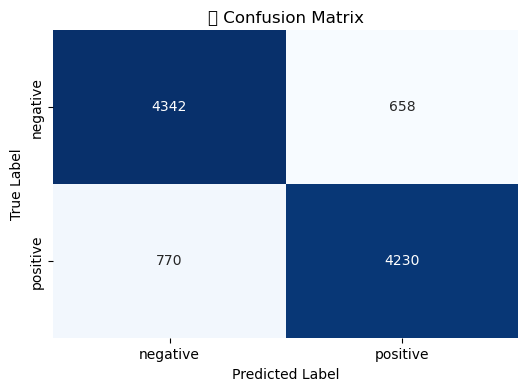

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("🔍 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
X_t, X_test = train_test_split(
    X_selected_df, test_size=0.3, random_state=42, stratify=y
)



In [59]:
print(X_t.head(10))
print(X_test.head(10))

      sentiment  abbot  able  ably  abominable  abomination  absent  \
27509  positive      0     0     0           0            0       0   
34629  positive      0     0     0           0            0       0   
15277  positive      0     0     0           0            0       0   
1062   negative      0     0     0           0            0       0   
38939  positive      0     0     0           0            0       0   
44977  positive      0     0     0           0            0       0   
47873  positive      0     0     0           0            0       0   
47133  positive      0     0     0           0            0       0   
27602  positive      0     0     0           0            0       0   
40844  positive      0     1     0           0            0       0   

       absolutely  absorbing  absurd  ...  youve  yuck  zenith  zephyr  \
27509           0          0       0  ...      0     0       0       0   
34629           0          0       0  ...      0     0       0       0

In [60]:
# Convert count-based values to binary: 1 if word appears, 0 if not
X_bernoulli = X_selected_df.drop(columns=['sentiment']).copy()
X_bernoulli = (X_bernoulli > 0).astype(int)

# Add back the sentiment column
X_bernoulli['sentiment'] = X_selected_df['sentiment']

# Step 0: Reorder the DataFrame to put 'sentiment' as the first column
cols = X_bernoulli.columns.tolist()
cols.insert(0, cols.pop(cols.index('sentiment')))  # Move 'sentiment' to front
X_bernoulli = X_bernoulli[cols]

# Preview
print(X_bernoulli.head())


  sentiment  abbot  able  ably  abominable  abomination  absent  absolutely  \
0  positive      0     0     0           0            0       0           0   
1  positive      0     0     0           0            0       0           0   
2  positive      0     0     0           0            0       0           0   
3  negative      0     0     0           0            0       0           0   
4  positive      0     0     0           0            0       0           0   

   absorbing  absurd  ...  youve  yuck  zenith  zephyr  zeppelin  zero  zeta  \
0          0       0  ...      0     0       0       0         0     0     0   
1          0       0  ...      0     0       0       0         0     0     0   
2          0       0  ...      0     0       0       0         0     0     0   
3          0       0  ...      0     0       0       0         0     0     0   
4          0       0  ...      0     0       0       0         0     0     0   

   zombie  zoom  zorro  
0       0     0    

In [71]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data
X = X_bernoulli.drop(columns=['sentiment'])
y = X_bernoulli['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train and evaluate
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.8632

📋 Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.86      0.86      5000
    positive       0.86      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


🔍 Confusion Matrix:
 [[4281  719]
 [ 649 4351]]


In [62]:
X_t, X_test = train_test_split(
    X_bernoulli, test_size=0.3, random_state=42, stratify=y
)

In [64]:
#print(X_t.head(10))
print(X_test.head(10))

      sentiment  abbot  able  ably  abominable  abomination  absent  \
48578  negative      0     0     0           0            0       0   
36663  negative      0     0     0           0            0       0   
25640  negative      0     0     0           0            0       0   
34655  negative      0     0     0           0            0       0   
11722  negative      0     0     0           0            0       0   
47394  negative      0     0     0           0            0       0   
25069  positive      0     0     0           0            0       0   
35304  positive      0     0     0           0            0       0   
46774  positive      0     0     0           0            0       0   
15473  negative      0     0     0           0            0       0   

       absolutely  absorbing  absurd  ...  youve  yuck  zenith  zephyr  \
48578           0          0       0  ...      0     0       0       0   
36663           0          0       0  ...      0     0       0       0

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


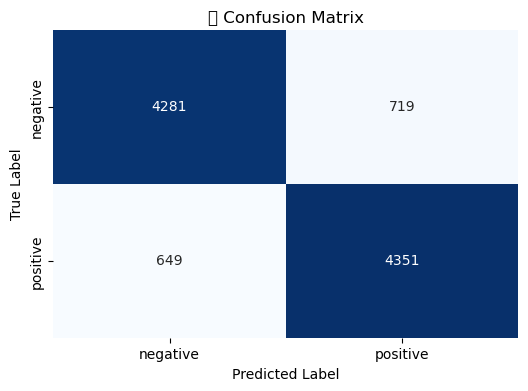

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("🔍 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()